In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-2.8.0-py2.py3-none-any.whl size=259932 sha256=7b0817039bd4a98540975e7b6e7cc0be19539bda8212542cfed2c03a32dba2f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-1bxjjkja/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('ok')

ok


In [ ]:
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd

project_id = 'amiable-nirvana-236805'
client = bigquery.Client(project=project_id)

train = client.query('''
SELECT * FROM `amiable-nirvana-236805.jeju_data_ver1.201901_202003_train` WHERE RAND() <1000 / (SELECT COUNT(*) FROM
`amiable-nirvana-236805.jeju_data_ver1.201901_202003_train`)''').to_dataframe()

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, title='Pandas Profiling Report', explorative=True)
profile.to_notebook_iframe()

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew

In [ ]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
!python --version

Pandas : 1.0.5
Numpy : 1.18.5
Scikit-Learn : 0.22.2.post1
Python 3.6.9


In [ ]:
def grap_year(data):
  data = str(data)
  return int(data[:4])
def grap_month(data):
  data = str(data)
  return int(data[4:])

In [ ]:
data = train.copy()
data = data.fillna('')
print(data['REG_YYMM'].head())

0    201904
1    201909
2    201901
3    201907
4    201908
Name: REG_YYMM, dtype: int64


In [ ]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'],axis=1)
data.head()

CARD_SIDO_NM CARD_CCG_NM  STD_CLSS_NM HOM_SIDO_NM  ...      AMT  CNT  year  month
0           경기     안산시 상록구      체인화 편의점          경기  ...  1189640  416  2019      4
1           부산          중구     서양식 음식점업          부산  ...    69100    5  2019      9
2           서울         은평구      체인화 편의점          경기  ...   161820   30  2019      1
3           경남     창원시 의창구      체인화 편의점          울산  ...    41880    9  2019      7
4           충남         서천군  차량용 주유소 운영업          경기  ...    75000    3  2019      8

[5 rows x 13 columns]

In [ ]:
df = data.drop(['CARD_CCG_NM','HOM_CCG_NM'],axis=1)

columns = ['CARD_SIDO_NM', 'STD_CLSS_NM','HOM_SIDO_NM','AGE','SEX_CTGO_CD','FLC','year','month']
df = df.groupby(columns).sum().reset_index(drop=False)

In [ ]:
def rmsle(y,pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle


 mu = 1716840.82 and sigma = 6045620.91



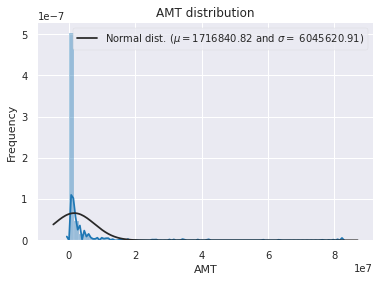

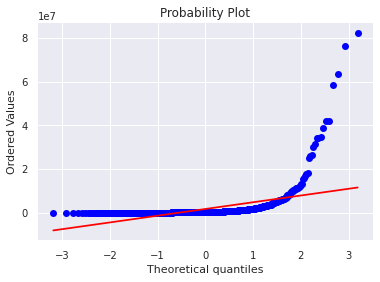

In [ ]:
sns.distplot(df['AMT'],fit=norm);
(mu, sigma) = norm.fit(df['AMT'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu,sigma))
plt.legend(['Normal dist. ($\mu=${:.2f} and $\sigma=$ {:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(df['AMT'],plot=plt)
plt.show()


 mu = 12.71 and sigma = 1.66



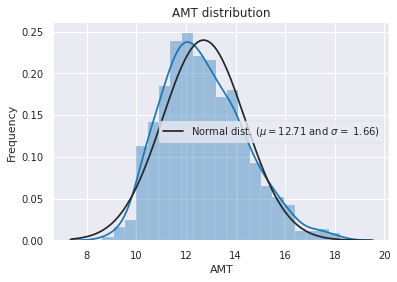

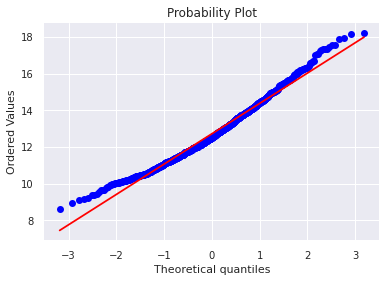

In [ ]:
df['AMT'] = np.log1p(df['AMT'])

sns.distplot(df['AMT'],fit=norm);
(mu, sigma) = norm.fit(df['AMT'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu,sigma))
plt.legend(['Normal dist. ($\mu=${:.2f} and $\sigma=$ {:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(df['AMT'],plot=plt)
plt.show()

In [ ]:
dtypes = df.dtypes
encoders = {}
for column in df.columns:
  if str(dtypes[column]) == 'object':
    encoder = LabelEncoder()
    encoder.fit(df[column])
    encoders[column] = encoder

df_num = df.copy()
for column in encoders.keys():
  encoder = encoders[column]
  df_num[column] = encoder.transform(df[column])

In [ ]:
train_num = df_num.sample(frac=1, random_state=0)
train_features = train_num.drop(['CSTMR_CNT','AMT','CNT'],axis=1)
train_target = train_num['AMT']

In [ ]:
gbm = GradientBoostingRegressor(n_estimators=4000);
gbm.fit(train_features, train_target)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=4000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
from itertools import product

CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [4, 7]

comb_list = [CARD_SIDO_NMs, STD_CLSS_NMs,HOM_SIDO_NMs, AGEs, SEX_CTGO_CDs, FLCs, years, months]
temp = np.array(list(product(*comb_list)))
temp = pd.DataFrame(data=temp, columns=train_features.columns)

In [ ]:
pred = gbm.predict(temp)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred,0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM','AMT']]
temp = temp.groupby(['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM']).sum().reset_index(drop=False)

In [ ]:
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [ ]:
print(temp.head())

   REG_YYMM CARD_SIDO_NM        STD_CLSS_NM           AMT
0    202004           강원         건강보조식품 소매업  2.584901e+08
1    202004           강원            골프장 운영업  8.603221e+08
2    202004           강원        과실 및 채소 소매업  8.814789e+08
3    202004           강원  관광 민예품 및 선물용품 소매업  1.906288e+09
4    202004           강원       그외 기타 종합 소매업  1.495484e+09


In [ ]:
submission = client.query('''
SELECT * FROM `amiable-nirvana-236805.jeju_data_ver1.submission` ''').to_dataframe()

In [ ]:
submission = submission.drop(['AMT'],axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],right_on=['REG_YYMM','CARD_SIDO_NM','STD_CLSS_NM'],how='left')
submission['AMT'] = submission['AMT'].fillna(0)
print(submission.head())

   id  REG_YYMM CARD_SIDO_NM           STD_CLSS_NM           AMT
0   0    202004           강원            건강보조식품 소매업  2.584901e+08
1   1    202004           강원               골프장 운영업  8.603221e+08
2   2    202004           강원           과실 및 채소 소매업  8.814789e+08
3   3    202004           강원     관광 민예품 및 선물용품 소매업  1.906288e+09
4   4    202004           강원  그외 기타 분류안된 오락관련 서비스업  0.000000e+00


In [ ]:
submission.to_csv('submission.csv', encoding='utf-8-sig', index=False)

NameError: ignored